# User identification project, final review

This is user identification project, our goal is identify a user with given sites he visited during the session and the time he visited each site. Our tasks are:
    
    -Make basic data analysis, visualise the data.
    -Identify features we will base our prediction on and extract it from the data.
    -Choose the best estimator to make a predictions
    -Rebuilt the data structure to make it acceptable by vowpal wabbit
    -Make predictions with Vowpal Wabbit 

**1. Data description**

The [data](https://inclass.kaggle.com/c/identify-me-if-you-can4/data) we have is information about 400 users browsing activity, presented by sessions. Each session consist of no more then 10 sites and could last not more, then 30 minutes. If user visited less then 10 sites until the end of the session or in 30 minutes, rest of site feature fields are filled by zero. Basically, I am going to use three sets of features:

-Sites user visited as bag of words

-Sequance user visited sites

-Time session starts

Ten user data which will be used during model selection part is available [here](https://yadi.sk/d/3gscKIdN3BCASG).

Let's take look on the data:

In [1]:
import os
import re
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.sparse import csr_matrix, hstack
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.datasets
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from glob import glob
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
import pickle

In [5]:
PATH_TO_DATA = 'C:/Users/ArseniiM/Python/C6/Project1'
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [112]:
train_df.shape

(182793, 21)

In [113]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,23713,2014-03-24 15:22:40,23720.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:48,23713.0,2014-03-24 15:22:54,23720.0,2014-03-24 15:22:54,...,2014-03-24 15:22:55,23713.0,2014-03-24 15:23:01,23713.0,2014-03-24 15:23:03,23713.0,2014-03-24 15:23:04,23713.0,2014-03-24 15:23:05,653
2,8726,2014-04-17 14:25:58,8725.0,2014-04-17 14:25:59,665.0,2014-04-17 14:25:59,8727.0,2014-04-17 14:25:59,45.0,2014-04-17 14:25:59,...,2014-04-17 14:26:01,45.0,2014-04-17 14:26:01,5320.0,2014-04-17 14:26:18,5320.0,2014-04-17 14:26:47,5320.0,2014-04-17 14:26:48,198
3,303,2014-03-21 10:12:24,19.0,2014-03-21 10:12:36,303.0,2014-03-21 10:12:54,303.0,2014-03-21 10:13:01,303.0,2014-03-21 10:13:24,...,2014-03-21 10:13:36,303.0,2014-03-21 10:13:54,309.0,2014-03-21 10:14:01,303.0,2014-03-21 10:14:06,303.0,2014-03-21 10:14:24,34
4,1359,2013-12-13 09:52:28,925.0,2013-12-13 09:54:34,1240.0,2013-12-13 09:54:34,1360.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:54:34,...,2013-12-13 09:54:34,1346.0,2013-12-13 09:54:34,1345.0,2013-12-13 09:54:34,1344.0,2013-12-13 09:58:19,1345.0,2013-12-13 09:58:19,601
5,11,2013-11-26 12:35:29,85.0,2013-11-26 12:35:31,52.0,2013-11-26 12:35:31,85.0,2013-11-26 12:35:32,11.0,2013-11-26 12:35:32,...,2013-11-26 12:35:32,11.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:03,10.0,2013-11-26 12:37:03,85.0,2013-11-26 12:37:04,273


Numbers in 'site' columns represent different sites. Site to number dictionary also provided.

Our goal is predict user_id on test data and submit it to kaggle in class competition. Test data has similar format

In [114]:
print(test_df.shape)
test_df.head()

(46473, 20)


,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,9,2014-10-04 12:24:43,304.0,2014-10-04 12:25:34,308.0,2014-10-04 12:28:33,307.0,2014-10-04 12:28:33,91.0,2014-10-04 12:28:33,308.0,2014-10-04 12:28:34,312.0,2014-10-04 12:30:31,300.0,2014-10-04 12:31:30,305.0,2014-10-04 12:32:31,309.0,2014-10-04 12:34:31
2,838,2014-12-02 09:20:37,504.0,2014-12-02 09:20:38,68.0,2014-12-02 09:20:38,11.0,2014-12-02 09:20:38,838.0,2014-12-02 09:20:38,11.0,2014-12-02 09:20:40,838.0,2014-12-02 09:20:41,886.0,2014-12-02 09:20:42,27.0,2014-12-02 09:20:42,305.0,2014-12-02 09:20:42
3,190,2014-10-01 09:27:38,192.0,2014-10-01 09:27:38,8.0,2014-10-01 09:27:38,189.0,2014-10-01 09:27:38,191.0,2014-10-01 09:27:39,189.0,2014-10-01 09:27:39,190.0,2014-10-01 09:27:39,2375.0,2014-10-01 09:27:39,192.0,2014-10-01 09:27:39,8.0,2014-10-01 09:27:39
4,295,2014-10-02 14:34:17,295.0,2014-10-02 14:34:18,295.0,2014-10-02 14:34:19,295.0,2014-10-02 14:34:20,295.0,2014-10-02 14:34:21,295.0,2014-10-02 14:34:22,295.0,2014-10-02 14:34:23,295.0,2014-10-02 14:34:24,295.0,2014-10-02 14:34:25,295.0,2014-10-02 14:34:26
5,31,2014-05-19 17:50:21,3177.0,2014-05-19 17:50:21,3174.0,2014-05-19 17:50:21,32434.0,2014-05-19 17:50:22,27.0,2014-05-19 17:50:22,31.0,2014-05-19 17:50:22,5698.0,2014-05-19 17:50:25,5698.0,2014-05-19 17:50:26,5698.0,2014-05-19 17:50:27,4173.0,2014-05-19 17:50:27


**2. Data processing**

Our next step is extraxting features we are interesting in.

First, let's use the time given. We will work only with time session starts, but extract two features from it: hour and day of week.

In [115]:
train_df['hour'] = train_df['time1'].apply(lambda x: pd.to_datetime(x).hour)
train_df['day_of_week'] = train_df['time1'].apply(lambda x: pd.to_datetime(x).dayofweek)

Another feature we are going to use is a number of unique sites visited per session.

In [116]:
counter = []
for index, row in tqdm(train_df[['site' + str(x) for x in range(1,11)]].iterrows()):
    count = len(np.unique(row.as_matrix()))
    if row.as_matrix()[9] == 0:
        count -= 1
    counter.append(count)
train_df['unique_sites'] = counter

182793it [00:20, 8750.31it/s]


Let's visualise new features we've created.

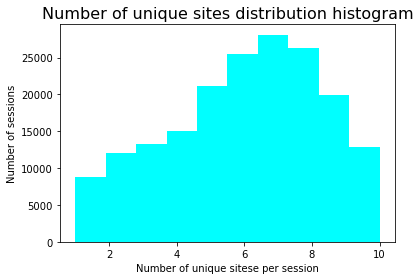

In [11]:
data = train_df['unique_sites']
plt.xlabel('Number of unique sitese per session')
plt.ylabel('Number of sessions')
plt.title('Number of unique sites distribution histogram', fontsize=16)
plt.hist(data, color='aqua')
plt.show()

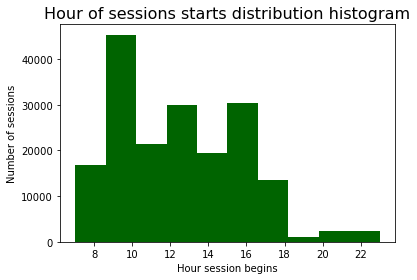

In [12]:
data = train_df['hour']
plt.xlabel('Hour session begins')
plt.ylabel('Number of sessions')
plt.title('Hour of sessions starts distribution histogram', fontsize=16)
plt.hist(data, color='darkgreen')
plt.show()

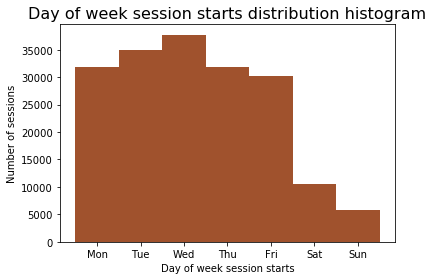

In [17]:
days_of_week = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
data = train_df['day_of_week']
plt.xlabel('Day of week session starts')
plt.ylabel('Number of sessions')
plt.title('Day of week session starts distribution histogram', fontsize=16)
plt.hist(data, color='sienna', bins=list(range(8)), align='left')
plt.xticks(range(7), days_of_week)
plt.show()

Now let's check, does new features help us to distinguish users or not.

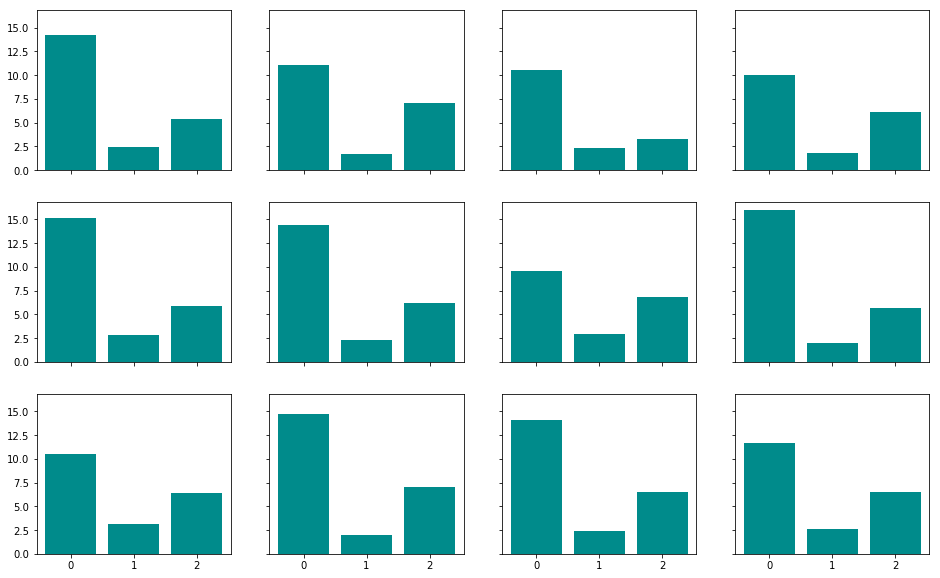

In [28]:
#Tree features put together for 12 random users
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
idx = 0
for i in  np.random.choice(train_df.user_id.values, 12):
    sub_df = train_df[train_df.user_id == i]
    axes[idx//4, idx%4].bar(list(range(3)), [sub_df.hour.mean(), sub_df.day_of_week.mean(), sub_df.unique_sites.mean()],
                           color='darkcyan')
    idx +=1

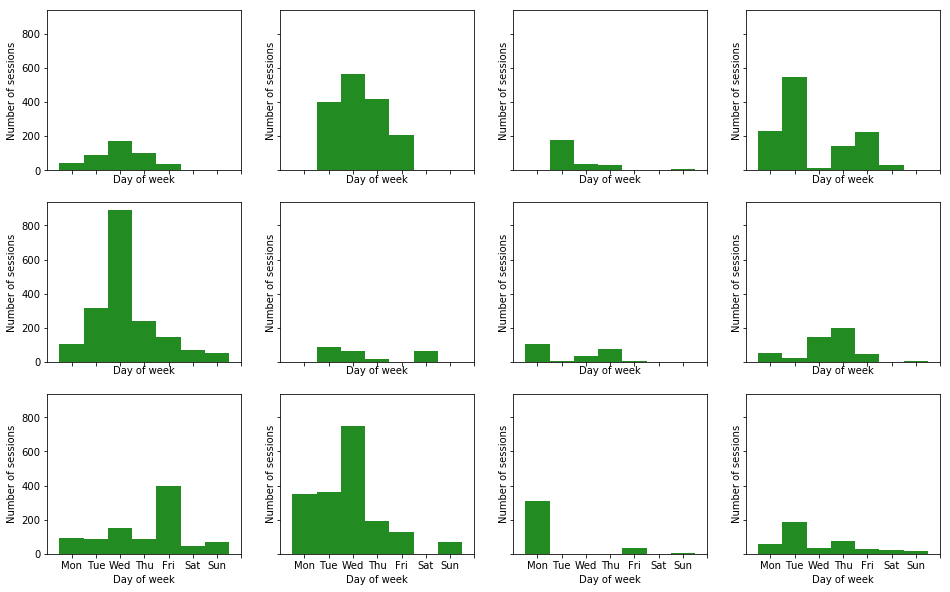

In [29]:
#Histograms of day of week sessions starts for 12 random users.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
idx = 0
for i in  np.random.choice(train_df.user_id.values, 12):
    sub_df = train_df[train_df.user_id == i]
    axes[idx//4, idx%4].hist(sub_df['day_of_week'], color='forestgreen', align='left', bins=list(range(8)))
    axes[idx//4, idx%4].set_xlabel('Day of week')
    axes[idx//4, idx%4].set_ylabel('Number of sessions')
    axes[idx//4, idx%4].set_xticks(list(range(8)))
    axes[idx//4, idx%4].set_xticklabels(days_of_week)
    axes[idx//4, idx%4].set_xlim((-1, 7))
    idx +=1

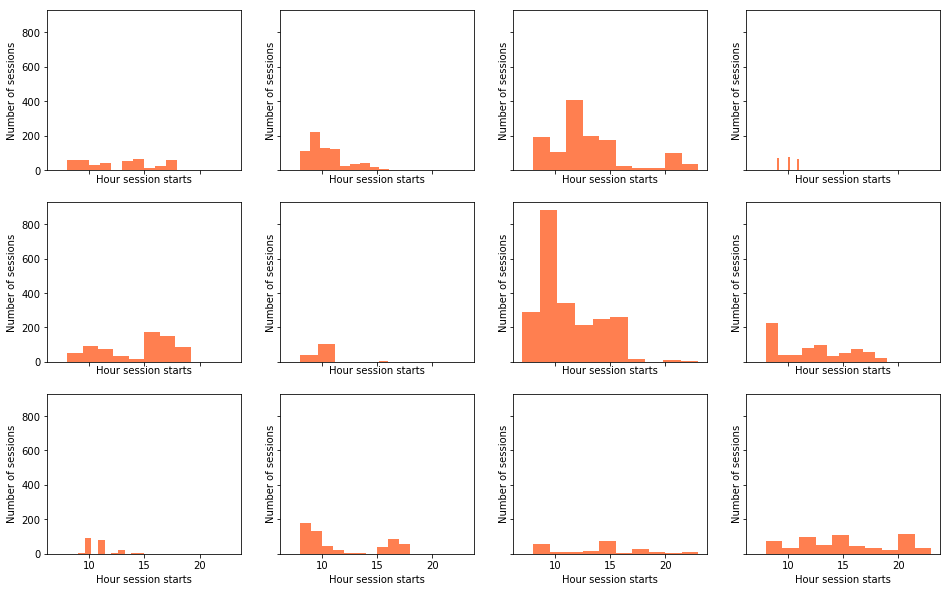

In [30]:
#Histograms of day of week sessions starts for 12 random users.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
idx = 0
for i in  np.random.choice(train_df.user_id.values, 12):
    sub_df = train_df[train_df.user_id == i]
    axes[idx//4, idx%4].hist(sub_df['hour'], color='coral')
    axes[idx//4, idx%4].set_xlabel('Hour session starts')
    axes[idx//4, idx%4].set_ylabel('Number of sessions')
    idx +=1

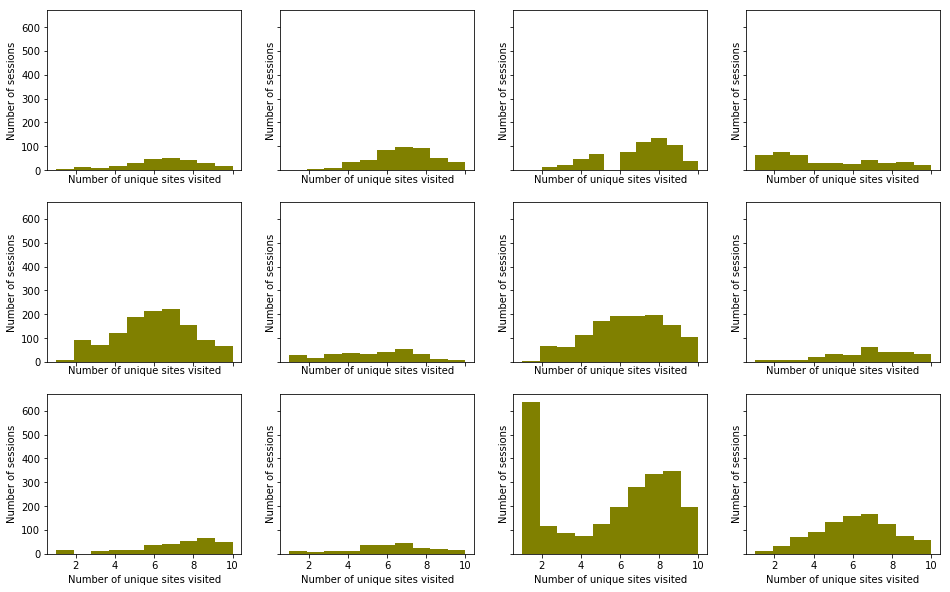

In [31]:
#Histograms of number of unique sites visited per sessionfor 12 random users.
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=True, sharey=True)
idx = 0
for i in  np.random.choice(train_df.user_id.values, 12):
    sub_df = train_df[train_df.user_id == i]
    axes[idx//4, idx%4].hist(sub_df['unique_sites'], color='olive')
    axes[idx//4, idx%4].set_xlabel('Number of unique sites visited')
    axes[idx//4, idx%4].set_ylabel('Number of sessions')
    idx +=1

So, as we could see, features we build could help us distinguish users. Now we need to do same transformation for test data.

In [117]:
test_df['hour'] = test_df['time1'].apply(lambda x: pd.to_datetime(x).hour)
test_df['day_of_week'] = test_df['time1'].apply(lambda x: pd.to_datetime(x).dayofweek)
counter = []
for index, row in tqdm(test_df[['site' + str(x) for x in range(1,11)]].iterrows()):
    count = len(np.unique(row.as_matrix()))
    if row.as_matrix()[9] == 0:
        count -= 1
    counter.append(count)
test_df['unique_sites'] = counter

46473it [00:05, 8777.15it/s]


*Addition*
With the train and test csv table, raw data is also provided. It consist of csv files with logs for each user.

In [36]:
PATH_TO_DATA = 'C:/Users/ArseniiM/Python/C6/Project1'
user1_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train/user0001.csv'))
user1_data.head()

,timestamp,site
0,2014-01-30 13:36:20,go.microsoft.com
1,2014-01-30 13:36:20,windows.microsoft.com
2,2014-01-30 13:36:20,res1.windows.microsoft.com
3,2014-01-30 13:36:20,js.microsoft.com
4,2014-01-30 13:36:20,ajax.microsoft.com


One of possible ways of improving prediction model if adjustment of basic parameters like session length, window length or maximum session time. Example function of another way of data table construction is given below.

In [3]:
def prepare_train_set_with_fe(path_to_csv_files, site_freq_path, feature_names,
                                    session_length=10, window_size=10):
    site_dict = pickle.load( open( site_freq_path, "rb" ) )
    big_list = np.array([0] * (session_length + 4))
    
    for filepath in glob(path_to_csv_files, recursive=False):
        user = int(re.search("([0-9]+)\.csv$", filepath).group(1))
        data = pd.read_csv(filepath)
        sites = np.hstack((data.site.values, np.array(['no_site']*session_length)))
        count = 0
        timeser = pd.to_datetime(data.timestamp)
        while count < data.shape[0]:
            #ses_time = int((timeser[min(len(timeser)-1,count+session_length-1)] - timeser[count]).total_seconds())
            un_sites = len(np.unique([site_dict[sites[i]][0] for i in range(count, min(len(timeser),count+session_length))]))
            hour = min(timeser[count], timeser[min(len(timeser)-1,count+session_length-1)]).hour
            dow = min(timeser[count], timeser[min(len(timeser)-1,count+session_length-1)]).dayofweek
            loc_list = np.array([site_dict[sites[i]][0] for i in range(count, count+session_length)]+
                                [un_sites]+[hour]+[dow]+[user])
            big_list = np.vstack((big_list, loc_list))
            
            count += window_size
        
    return pd.DataFrame(big_list[1:,:], columns=['site' + str(x) for x in range(1, 11)] + feature_names+['user_id'])

**Model selection**

In this part we are going to try different prediction models for our task. To save time, we will work with smaller dataset which consist of only ten users. We will take sprased sites matrix as a basic data and add up site sequence and new constructed  features as additional data.

In [14]:
%%time
feature_names = ['unique_sites', 'hour', 'day_of_week']
data_10us = prepare_train_set_with_fe(os.path.join(PATH_TO_DATA, '10users/*'), os.path.join(PATH_TO_DATA, 'site_freq_10users.pkl'),
                          feature_names,session_length=10, window_size=10)
y_10us = data_10us.user_id.values

Wall time: 3.94 s


Next step we need to vectorize sites features to make it bag of words form.

In [7]:
def matrix_vect(matrix):
    matrix = np.array(matrix)
    data_list = []
    row_list = []
    col_list = []
    for i in range(matrix.shape[0]):
        freq = np.unique(matrix[i], return_counts=True)
        for j in range(len(freq[0])):
            if freq[0][j] != 0:
                data_list.append(freq[1][j])
                row_list.append(i)
                col_list.append(freq[0][j]-1)
    result = csr_matrix((data_list, (row_list, col_list)), shape=(matrix.shape[0], matrix.max()))
    
    return result

In [15]:
X_10us_sparse = matrix_vect(data_10us[['site' + str(x) for x in range(1,11)]])

In [16]:
X_10us_ss_af = hstack([X_10us_sparse, csr_matrix(data_10us.as_matrix()[:,:-1])])

In [17]:
X_10us_af = hstack([X_10us_sparse, csr_matrix(data_10us[['day_of_week','hour','unique_sites']].as_matrix()[:,:])])

In [18]:
X_10us_ss = hstack([X_10us_sparse, csr_matrix(data_10us[['site' + str(x) for x in range(1,11)]].as_matrix()[:,:])])

In [26]:
X_train, X_valid, X_train_af, X_valid_af,\
X_train_ss, X_valid_ss, X_train_ss_af, X_valid_ss_af,\
y_train, y_valid = train_test_split(X_10us_sparse, X_10us_af, X_10us_ss,
                                    X_10us_ss_af, y_10us,test_size=0.3, 
                                                     random_state=7, stratify=y_10us)

Define folding function we use to perform cross-validation

In [21]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=17)

As a first step let's try n neighbors classifier with different number of neighbors.

In [65]:
#Only site vectorized data
from sklearn.neighbors import KNeighborsClassifier
n_neighbors = [1, 5, 10, 50, 100]
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    cvs = cross_val_score(knn, X_train, y_train, cv=skf)
    knn.fit(X_train, y_train)
    cvs2 = accuracy_score(y_valid, knn.predict(X_valid))
    print(cvs.mean(), cvs2)

0.661656279913 0.67243422612
0.68085726571 0.694477364304
0.67181136715 0.67053804219
0.60546351984 0.619578099076
0.561265703976 0.573832661768


In [66]:
#Site vectorized plus site sequence
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    cvs = cross_val_score(knn, X_train_ss, y_train, cv=skf)
    knn.fit(X_train_ss, y_train)
    cvs2 = accuracy_score(y_valid, knn.predict(X_valid_ss))
    print(cvs.mean(), cvs2)

0.422274643719 0.430433752074
0.423188473765 0.438255510785
0.415262473777 0.425456269258
0.351350807221 0.369044797345
0.29882054861 0.328750888836


In [67]:
#Site vectorized plus additional features
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    cvs = cross_val_score(knn, X_train_af, y_train, cv=skf)
    knn.fit(X_train_af, y_train)
    cvs2 = accuracy_score(y_valid, knn.predict(X_valid_af))
    print(cvs.mean(), cvs2)

0.750557502617 0.758236548945
0.743651942865 0.764636169708
0.72231362126 0.744489215454
0.63533864984 0.657975823655
0.592763726058 0.607252903532


In [68]:
#Site vectorized plus site sequence and additional features
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    cvs = cross_val_score(knn, X_train_ss_af, y_train, cv=skf)
    knn.fit(X_train_ss_af, y_train)
    cvs2 = accuracy_score(y_valid, knn.predict(X_valid_ss_af))
    print(cvs.mean(), cvs2)

0.436704186283 0.449632614364
0.436804729242 0.454847120171
0.427760161418 0.440151694714
0.35643034734 0.378051671012
0.303392546382 0.332069210713


So, we obtain two important results:

-N neighbors classifier gives us the best result with small number neighbors, less the 10

-Additional features we constructed improve our prediction accuracy, while site sequence features only spoil data. Later on we will try to use it by exctracting n-grams.

Let's try random forest classifier as a next step

In [70]:
from sklearn.ensemble import RandomForestClassifier
rfc1 = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
rfc1.fit(X_train, y_train)
print(rfc1.oob_score_, accuracy_score(y_valid, rfc1.predict(X_valid)))

rfc2 = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
rfc2.fit(X_train_ss, y_train)
print(rfc2.oob_score_, accuracy_score(y_valid, rfc2.predict(X_valid_ss)))

rfc3 = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
rfc3.fit(X_train_af, y_train)
print(rfc3.oob_score_, accuracy_score(y_valid, rfc3.predict(X_valid_af)))

rfc4 = RandomForestClassifier(n_estimators=100, random_state=17, oob_score=True)
rfc4.fit(X_train_ss_af, y_train)
print(rfc4.oob_score_, accuracy_score(y_valid, rfc4.predict(X_valid_ss_af)))

0.725767120504 0.711780042664
0.757264783581 0.753733112112
0.803393619183 0.804219009244
0.804917699655 0.799241526428


As we could observe, random forest work differently and site sequence data doesn't spoil it's prediction accuracy, but also couldn't improve it versus additional features.

As a next step we could try **logistic regression**.

In [27]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

logit1 = LogisticRegression(random_state=17)
cvs = cross_val_score(logit1, X_train, y_train, cv=skf)
logit1.fit(X_train, y_train)
acc_sc = accuracy_score(y_valid, logit1.predict(X_valid))
print(cvs.mean(), acc_sc)

logit2 = LogisticRegression(random_state=17)
cvs = cross_val_score(logit2, X_train_ss, y_train, cv=skf)
logit2.fit(X_train_ss, y_train)
acc_sc = accuracy_score(y_valid, logit2.predict(X_valid_ss))
print(cvs.mean(), acc_sc)

logit3 = LogisticRegression(random_state=17)
cvs = cross_val_score(logit3, X_train_af, y_train, cv=skf)
logit3.fit(X_train_af, y_train)
acc_sc = accuracy_score(y_valid, logit3.predict(X_valid_af))
print(cvs.mean(), acc_sc)

logit4 = LogisticRegression(random_state=17)
cvs = cross_val_score(logit4, X_train_ss_af, y_train, cv=skf)
logit4.fit(X_train_ss_af, y_train)
acc_sc = accuracy_score(y_valid, logit4.predict(X_valid_ss_af))
print(cvs.mean(), acc_sc)

0.764888732699 0.778620526191
0.758485792331 0.761554870822
0.779521743944 0.78810144584
0.777082779652 0.782649917042


Site sequence parametr doesn't give us any improvment, but also doesn't spoil prediction accuracy. Let's use our best data set to choose regularization parameter C.

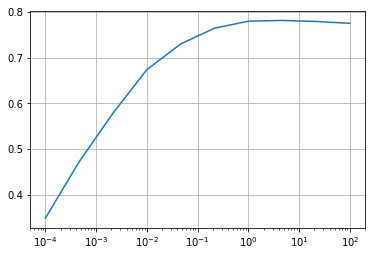

In [74]:
logit_c_values1 = np.logspace(-4, 2, 10)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1) 
logit_grid_searcher1.fit(X_train_af, y_train)

logit_mean_cv_scores1 = []
scores = logit_grid_searcher1.scores_[31]
for i in range(10):
    logit_mean_cv_scores1.append(np.array([scores[0][i], scores[1][i], scores[2][i]]).mean())
    
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.grid()
plt.xscale('log')

So, we got best score somewhere between 0 and 10, let's do further search.

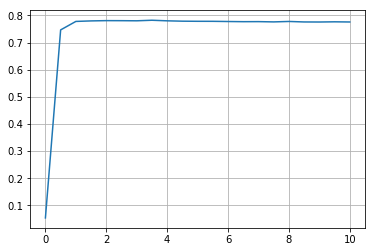

In [81]:
logit_c_values1 = np.linspace(0, 10, 21)

logit_grid_searcher1 = LogisticRegressionCV(Cs=logit_c_values1, multi_class='multinomial', random_state=17, cv=skf, n_jobs=-1) 
logit_grid_searcher1.fit(X_train_af, y_train)

logit_mean_cv_scores1 = []
scores = logit_grid_searcher1.scores_[31]
for i in range(21):
    logit_mean_cv_scores1.append(np.array([scores[0][i], scores[1][i], scores[2][i]]).mean())
    
plt.plot(logit_c_values1, logit_mean_cv_scores1)
plt.grid()

In [84]:
np.amax(logit_mean_cv_scores1), np.argmax(logit_mean_cv_scores1)

(0.7819577056321857, 7)

So the best C is 3.5, let's see what accuraccy we could get with this parameter

In [85]:
logit2 = LogisticRegression(random_state=17, C=3.5)
cvs2 = cross_val_score(logit2, X_train_af, y_train, cv=skf)
logit2.fit(X_train_af, y_train)
acc_sc2 = accuracy_score(y_valid, logit2.predict(X_valid_af))
print(cvs2.mean(), acc_sc2)

0.779316666212 0.7918938137


This accuracy is higher then one we got before parameter selection but still slightly less then random forest best result.

The next step is **Support vector machine**.

In [86]:
from sklearn.svm import LinearSVC

svm = LinearSVC(C=1, random_state=17)
cvs = cross_val_score(svm, X_train, y_train, cv=skf)
svm.fit(X_train, y_train)
acc_sc = accuracy_score(y_valid, svm.predict(X_valid))
print(cvs.mean(), acc_sc)

svm = LinearSVC(C=1, random_state=17)
cvs = cross_val_score(svm, X_train_ss, y_train, cv=skf)
svm.fit(X_train_ss, y_train)
acc_sc = accuracy_score(y_valid, svm.predict(X_valid_ss))
print(cvs.mean(), acc_sc)

svm = LinearSVC(C=1, random_state=17)
cvs = cross_val_score(svm, X_train_af, y_train, cv=skf)
svm.fit(X_train_af, y_train)
acc_sc = accuracy_score(y_valid, svm.predict(X_valid_af))
print(cvs.mean(), acc_sc)

svm = LinearSVC(C=1, random_state=17)
cvs = cross_val_score(svm, X_train_ss_af, y_train, cv=skf)
svm.fit(X_train_ss_af, y_train)
acc_sc = accuracy_score(y_valid, svm.predict(X_valid_ss_af))
print(cvs.mean(), acc_sc)

0.75777667065 0.770324721498
0.199425733695 0.272813462906
0.770477548263 0.779568618156
0.280917299793 0.374970372126


As we could see, site sequence features really spoils the result, which is not surprising. Let's also perform parametr selection and see, how better result we could obtain.

In [102]:
svm_params1 = {'C': np.logspace(-3, 3, 7)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params1)
svm_grid_searcher1.fit(X_train_af, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [103]:
svm_grid_searcher1.cv_results_['mean_test_score'].max(), svm_grid_searcher1.best_params_

(0.77768746189798821, {'C': 0.10000000000000001})

In [105]:
svm_params2 = {'C': np.linspace(1e-4, 2, 21)}

svm_grid_searcher1 = GridSearchCV(svm, param_grid=svm_params2)
svm_grid_searcher1.fit(X_train_af, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=LinearSVC(C=1, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=17, tol=0.0001,
     verbose=0),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   1.00095e-01,   2.00090e-01,   3.00085e-01,
         4.00080e-01,   5.00075e-01,   6.00070e-01,   7.00065e-01,
         8.00060e-01,   9.00055e-01,   1.00005e+00,   1.10004e+00,
         1.20004e+00,   1.30004e+00,   1.40003e+00,   1.50002e+00,
         1.60002e+00,   1.70002e+00,   1.80001e+00,   1.90000e+00,
         2.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [106]:
svm_grid_searcher1.cv_results_['mean_test_score'].max(), svm_grid_searcher1.best_params_

(0.77768746189798821, {'C': 0.100095})

Thus, default C is roughly the best parameter for this SVM.

**Results**

-Site sequence data doesn't give us any improvment but could spoil the result, thus we shouldn;t use it.

-Random forest estimator gives us the best accuracy, but linear regression result roughly the same, while it's much more easier to optimize it by gradient descent, thus we will use a linear regression mostly.

**Working with Vowpal wabbit**

In this section we arer going to work with Vowpal wabbit. First of all we need to transform data to the format Vowpal could read.

In [203]:
#Function to transform given format to vw
def table_to_vw(X, y=None, out_file='tmp.vw'):
    if y is None:
        l = np.ones((X.shape[0],), dtype=np.int)
    else:
        l = y
    file = open(out_file, "w")
    file.close()
    j = 0    
    for row in tqdm(X):
        locstr = str(l[j]) + ' |sites'
        for site, count in zip(np.unique(row[:10], return_counts=True)[0], np.unique(row[:10], return_counts=True)[1]):
            if site != 0:
                locstr += ' '+str(site)+':'+str(count)
        
        locstr += ' |pages'
        i = 0
        for page in row[:10]:
            locstr += ' '+str(i)+':'+str(page)
            i +=1
        
        locstr += ' |adds'
        i = 0
        for add in row[10:]:
            locstr += ' '+str(i)+':'+str(add)
            i += 1
        locstr += '\n'
        with open(out_file, 'a') as vw_data:
                vw_data.write(locstr)
        j += 1

We need to make class label accepted by vowpal from our user id numbers.

In [118]:
class_encoder = LabelEncoder()
y = class_encoder.fit_transform(train_df.user_id.values) + 1

Separate train and validation data

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(train_df.fillna(0)[tags].as_matrix().astype(int), y,test_size=0.3, 
                                                     random_state=7, stratify=y)

Rebuild data to vowpal format

In [223]:
table_to_vw(X_train, y_train, out_file='Train.vw')
table_to_vw(X_valid, out_file='Valid.vw')

100%|███████████████████████████████████| 54838/54838 [01:54<00:00, 480.19it/s]


**Model 1:** Basic model

In [224]:
%%time
!vw -d Train.vw --oaa 400  -f model1.vw --passes 3 -c -k -b 26 --random_seed 17 --ignore p,a

ignoring namespaces beginning with: p , a 
final_regressor = model1.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Train.vw.cache
Reading datafile = Train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      266        1        9
1.000000 1.000000            2            2.0      319      266       10
1.000000 1.000000            4            4.0      180      319        8
1.000000 1.000000            8            8.0       83      266        2
1.000000 1.000000           16           16.0      379        5        8
1.000000 1.000000           32           32.0       78      139        2
0.968750 0.937500           64           64.0      295      394        9
0.968750 0.968750          128          128.0       64        2        4
0.953125 0.937500        

Wall time: 1min 23s


In [225]:
!vw -t -i model1.vw -d Valid.vw -p pred1.csv

ignoring namespaces beginning with: p , a 
only testing
predictions = pred1.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1        6       11
1.000000 1.000000            2            2.0        1      341        6
1.000000 1.000000            4            4.0        1      334        6
1.000000 1.000000            8            8.0        1       48        3
1.000000 1.000000           16           16.0        1       24        9
1.000000 1.000000           32           32.0        1      295        9
1.000000 1.000000           64           64.0        1      144        8
1.000000 1.000000          128          128.0        1      348        2
1.000000 1.000000          256          256.0        1      19

In [226]:
pred = pd.read_csv('pred1.csv', names=['ans'])
accuracy_score(y_valid, pred.ans.values)

0.35898464568365002

**Model 2:** Model with site sequences

In [227]:
%%time
!vw -d Train.vw --oaa 400  -f model2.vw --passes 3 -c -k -b 26 --random_seed 17 --ignore a

ignoring namespaces beginning with: a 
final_regressor = model2.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Train.vw.cache
Reading datafile = Train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      266        1       19
1.000000 1.000000            2            2.0      319      266       20
1.000000 1.000000            4            4.0      180        5       18
1.000000 1.000000            8            8.0       83      178        7
1.000000 1.000000           16           16.0      379        5       18
0.968750 0.937500           32           32.0       78       83        7
0.968750 0.968750           64           64.0      295      151       19
0.984375 1.000000          128          128.0       64        2       14
0.992188 1.000000          25

Wall time: 1min 18s


In [228]:
!vw -t -i model2.vw -d Valid.vw -p pred2.csv

ignoring namespaces beginning with: a 
only testing
predictions = pred2.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1       21       21
1.000000 1.000000            2            2.0        1      341       16
1.000000 1.000000            4            4.0        1      334       16
1.000000 1.000000            8            8.0        1       48       13
1.000000 1.000000           16           16.0        1       24       19
1.000000 1.000000           32           32.0        1      295       19
1.000000 1.000000           64           64.0        1      144       18
1.000000 1.000000          128          128.0        1      348        3
1.000000 1.000000          256          256.0        1      190   

In [229]:
pred = pd.read_csv('pred2.csv', names=['ans'])
accuracy_score(y_valid, pred.ans.values)

0.35816404682884129

**Model 3:** with additional features

In [230]:
%%time
!vw -d Train.vw --oaa 400  -f model3.vw --passes 3 -c -k -b 26 --random_seed 17 --ignore p

ignoring namespaces beginning with: p 
final_regressor = model3.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Train.vw.cache
Reading datafile = Train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      266        1       12
1.000000 1.000000            2            2.0      319      266       13
1.000000 1.000000            4            4.0      180      319       11
1.000000 1.000000            8            8.0       83      397        5
1.000000 1.000000           16           16.0      379        5       11
1.000000 1.000000           32           32.0       78      139        5
0.968750 0.937500           64           64.0      295      162       11
0.968750 0.968750          128          128.0       64        2        7
0.945313 0.921875          25

Wall time: 1min 15s


In [231]:
!vw -t -i model3.vw -d Valid.vw -p pred3.csv

ignoring namespaces beginning with: p 
only testing
predictions = pred3.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      128       14
1.000000 1.000000            2            2.0        1      341        9
1.000000 1.000000            4            4.0        1      334        9
1.000000 1.000000            8            8.0        1      160        6
1.000000 1.000000           16           16.0        1       24       11
1.000000 1.000000           32           32.0        1       42       12
1.000000 1.000000           64           64.0        1       30       11
1.000000 1.000000          128          128.0        1      312        5
1.000000 1.000000          256          256.0        1      168   

In [232]:
pred = pd.read_csv('pred3.csv', names=['ans'])
accuracy_score(y_valid, pred.ans.values)

0.37898902221087566

**Model 4:** With all available data

In [233]:
%%time
!vw -d Train.vw --oaa 400  -f model4.vw --passes 3 -c -k -b 26 --random_seed 17

final_regressor = model4.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Train.vw.cache
Reading datafile = Train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      266        1       22
1.000000 1.000000            2            2.0      319      266       23
1.000000 1.000000            4            4.0      180        5       21
1.000000 1.000000            8            8.0       83      178       10
1.000000 1.000000           16           16.0      379       59       21
0.968750 0.937500           32           32.0       78       83       10
0.968750 0.968750           64           64.0      295      151       21
0.984375 1.000000          128          128.0       64        2       17
0.988281 0.992188          256          256.0      178      326     

Wall time: 1min 8s


In [236]:
!vw -t -i model4.vw -d Valid.vw -p pred4.csv

only testing
predictions = pred4.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      128       24
1.000000 1.000000            2            2.0        1      341       19
1.000000 1.000000            4            4.0        1      334       19
1.000000 1.000000            8            8.0        1      160       16
1.000000 1.000000           16           16.0        1       24       21
1.000000 1.000000           32           32.0        1       42       22
1.000000 1.000000           64           64.0        1       30       21
1.000000 1.000000          128          128.0        1      312        6
1.000000 1.000000          256          256.0        1      168       19
1.000000 1.000000          512  

In [237]:
pred = pd.read_csv('pred4.csv', names=['ans'])
accuracy_score(y_valid, pred.ans.values)

0.37796783252489152

**Model 5:** with all data and ngrams

In [238]:
%%time
!vw -d Train.vw --oaa 400  -f model5.vw --passes 3 -c -k -b 26 --random_seed 17 --ngram p3

Generating 3-grams for p namespaces.
final_regressor = model5.vw
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Train.vw.cache
Reading datafile = Train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      266        1       39
1.000000 1.000000            2            2.0      319      266       40
1.000000 1.000000            4            4.0      180        5       38
1.000000 1.000000            8            8.0       83       20       17
1.000000 1.000000           16           16.0      379       59       38
0.968750 0.937500           32           32.0       78       83       17
0.984375 1.000000           64           64.0      295      151       38
0.992188 1.000000          128          128.0       64        2       34
0.992188 0.992188          256 

Wall time: 1min 14s


In [239]:
!vw -t -i model5.vw -d Valid.vw -p pred5.csv

Generating 3-grams for p namespaces.
only testing
predictions = pred5.csv
Num weight bits = 26
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Valid.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      128       41
1.000000 1.000000            2            2.0        1      341       36
1.000000 1.000000            4            4.0        1      334       36
1.000000 1.000000            8            8.0        1      160       33
1.000000 1.000000           16           16.0        1       24       38
1.000000 1.000000           32           32.0        1       42       39
1.000000 1.000000           64           64.0        1       30       38
1.000000 1.000000          128          128.0        1      266        6
1.000000 1.000000          256          256.0        1      168     

In [240]:
pred = pd.read_csv('pred5.csv', names=['ans'])
accuracy_score(y_valid, pred.ans.values)

0.36204821474160254

Now we could submit result to competition

In [256]:
%%time
!vw -d Data2.vw --oaa 400  -f model6.vw --passes 3 -c -k -b 24 --random_seed 17 --ignore p

ignoring namespaces beginning with: p 
final_regressor = model6.vw
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = Data2.vw.cache
Reading datafile = Data2.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0      262        1        5
1.000000 1.000000            2            2.0       82      262       10
1.000000 1.000000            4            4.0      241       16       11
1.000000 1.000000            8            8.0      352      262        6
1.000000 1.000000           16           16.0      135       16        7
1.000000 1.000000           32           32.0       71      112        8
0.968750 0.937500           64           64.0      358        9        8
0.976563 0.984375          128          128.0      348      281       13
0.949219 0.921875          25

Wall time: 1min 34s


In [258]:
!vw -t -i model6.vw -d Target2.vw -p Target2.csv

ignoring namespaces beginning with: p 
only testing
predictions = Target2.csv
Num weight bits = 24
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = Target2.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0        1      310       13
1.000000 1.000000            2            2.0        1       59       11
1.000000 1.000000            4            4.0        1      265        5
1.000000 1.000000            8            8.0        1      137        7
1.000000 1.000000           16           16.0        1      273       10
1.000000 1.000000           32           32.0        1       85        6
1.000000 1.000000           64           64.0        1      298       14
1.000000 1.000000          128          128.0        1      129        5
1.000000 1.000000          256          256.0        1      11

In [259]:
def write_to_submission_file(predicted_labels, out_file,
                             target='user_id', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [260]:
vm_pred=pd.read_csv('Target2.csv', names=['ans'])
vm_pred['user_id']=vm_pred['ans'].apply(lambda x: class_encoder.inverse_transform(x-1))
write_to_submission_file(vm_pred['user_id'].values, 'vm_pred.csv')

Unforunatelly, this model gives worse results compare to basic model only with vectorized sites visited

**Conclusion**

During this project I did basic data processing, feature construction and data selection. Based on this date I tasted an efficiency of different models and choosed optimal one.

This model could be used to identify user by any sequantial data. That could be not only web-pages, but, for example places user visited, which could be observed by connection to local wi-fi.

This model could be further improved by feture construction or more sophisticated parameter selection.